# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Download the data

In [1]:
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
!
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   187  100   187    0     0    222      0 --:--:-- --:--:-- --:--:--   222
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   187  100   187    0     0    291      0 --:--:-- --:--:-- --:--:--   291
tar: This does not look like a tar archive

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
tar: This does not look like a tar archive

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


## Prepare paths of input images and target segmentation masks

In [3]:
!unzip "/content/annotations.zip" -d "/content/annotations" #

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_169.png  
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_17.png  
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_170.png  
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_171.png  
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_172.png  
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_173.png  
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_174.png  
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_175.png  
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_176.png  
  inflating: /content/annotations/annotations/annotations/trimaps/scottish_terrier_177.png  
  inflating: /

In [4]:
!unzip "/content/images.zip" -d "/content/images" #

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/images/images/images/Egyptian_Mau_90.jpg  
  inflating: /content/images/images/images/Egyptian_Mau_91.jpg  
  inflating: /content/images/images/images/Egyptian_Mau_92.jpg  
  inflating: /content/images/images/images/Egyptian_Mau_93.jpg  
  inflating: /content/images/images/images/Egyptian_Mau_94.jpg  
  inflating: /content/images/images/images/Egyptian_Mau_95.jpg  
  inflating: /content/images/images/images/Egyptian_Mau_96.jpg  
  inflating: /content/images/images/images/Egyptian_Mau_97.jpg  
  inflating: /content/images/images/images/Egyptian_Mau_98.jpg  
  inflating: /content/images/images/images/Egyptian_Mau_99.jpg  
  inflating: /content/images/images/images/english_cocker_spaniel_1.jpg  
  inflating: /content/images/images/images/english_cocker_spaniel_10.jpg  
  inflating: /content/images/images/images/english_cocker_spaniel_100.jpg  
  inflating: /content/images/images/images/english_cocker_spaniel_10

In [6]:
import os

input_dir = "images/images/images/"
target_dir = "annotations/annotations/annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/images/images/Abyssinian_1.jpg | annotations/annotations/annotations/trimaps/Abyssinian_1.png
images/images/images/Abyssinian_10.jpg | annotations/annotations/annotations/trimaps/Abyssinian_10.png
images/images/images/Abyssinian_100.jpg | annotations/annotations/annotations/trimaps/Abyssinian_100.png
images/images/images/Abyssinian_101.jpg | annotations/annotations/annotations/trimaps/Abyssinian_101.png
images/images/images/Abyssinian_102.jpg | annotations/annotations/annotations/trimaps/Abyssinian_102.png
images/images/images/Abyssinian_103.jpg | annotations/annotations/annotations/trimaps/Abyssinian_103.png
images/images/images/Abyssinian_104.jpg | annotations/annotations/annotations/trimaps/Abyssinian_104.png
images/images/images/Abyssinian_105.jpg | annotations/annotations/annotations/trimaps/Abyssinian_105.png
images/images/images/Abyssinian_106.jpg | annotations/annotations/annotations/trimaps/Abyssinian_106.png
images/images/images/Abyssinian_107.j

## What does one input image and corresponding segmentation mask look like?

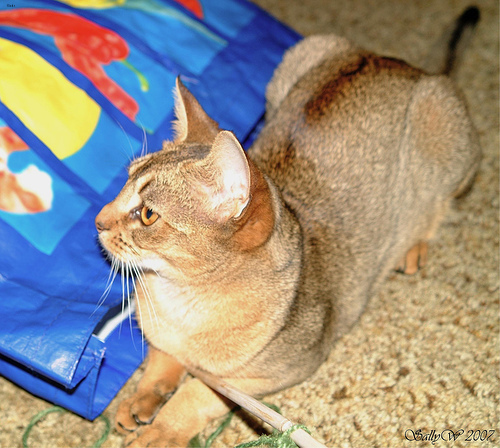

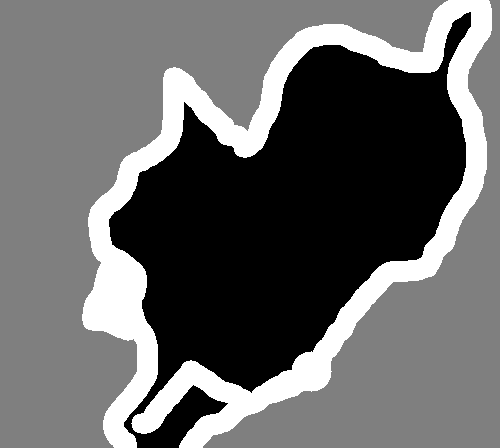

In [7]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare dataset to load & vectorize batches of data

In [9]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## Prepare U-Net Xception-style model

In [10]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 80, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 80, 80, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 80, 80, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 80, 80, 32)     │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 80, 80, 64)     │          2,400 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 80, 80, 64)     │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 80, 80, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 80, 80, 64)     │          4,736 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 80, 80, 64)     │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 40, 40, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 40, 40, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 40, 40, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 40, 40, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 40, 40, 128)    │          8,896 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

## Set aside a validation split

In [11]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

## Train the model

In [12]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50
32/32 - 66s - 2s/step - loss: 1.4779 - val_loss: 2.0254
Epoch 2/50
32/32 - 40s - 1s/step - loss: 0.8642 - val_loss: 1.3917
Epoch 3/50
32/32 - 13s - 402ms/step - loss: 0.7389 - val_loss: 1.5751
Epoch 4/50
32/32 - 7s - 213ms/step - loss: 0.6766 - val_loss: 2.0618
Epoch 5/50
32/32 - 10s - 326ms/step - loss: 0.6338 - val_loss: 2.6249
Epoch 6/50
32/32 - 6s - 185ms/step - loss: 0.5997 - val_loss: 3.1821
Epoch 7/50
32/32 - 10s - 321ms/step - loss: 0.5702 - val_loss: 3.7095
Epoch 8/50
32/32 - 7s - 227ms/step - loss: 0.5429 - val_loss: 4.1778
Epoch 9/50
32/32 - 9s - 280ms/step - loss: 0.5169 - val_loss: 4.5716
Epoch 10/50
32/32 - 7s - 219ms/step - loss: 0.4913 - val_loss: 4.8963
Epoch 11/50
32/32 - 6s - 187ms/step - loss: 0.4655 - val_loss: 5.1495
Epoch 12/50
32/32 - 10s - 322ms/step - loss: 0.4395 - val_loss: 5.3314
Epoch 13/50
32/32 - 7s - 218ms/step - loss: 0.4140 - val_loss: 5.4291
Epoch 14/50
32/32 - 12s - 369ms/step - loss: 0.3894 - val_loss: 5.3889
Epoch 15/50
32/32 - 8s - 238

## Visualize predictions

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step


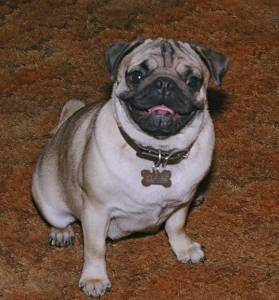

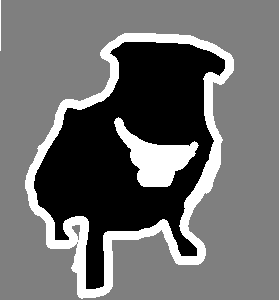

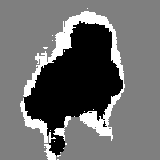

In [13]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [14]:
model_path = "oxford_segmentation.h5"
model.save(model_path)